커뮤니티 탐지 방법을 사용해 사기 집단 찾기. 

`Louvain` 알고리즘   
: 복잡한 네트워크 내에서 밀접하게 연결된 노드 그룹, 즉 커뮤니티를 찾아내는 데 유용.     
: 핵심은 모듈성 지표를 최대화 하는 것       
: 모듈성은 네트워크가 얼마나 잘 분할되어 있는지를 나타내며, 커뮤니티 내 연결은 매우 밀접하고, 커뮤니티 간 연결은 상대적으로 드물 때 높은 값을 가짐

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from faker import Faker
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import networkx as nx
from community import community_louvain
from concurrent.futures import ThreadPoolExecutor, as_completed

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
# 임의 데이터 생성 
fake = Faker()
start_date = datetime(2024, 5, 1)
num_days = 15
num_users = 3000
transactions_per_user = 5

# 사용자 정보 초기화
users = pd.DataFrame({
    'user_id': range(num_users),
    'ip': [fake.ipv4() for _ in range(num_users)],
    'device_id': [fake.uuid4() for _ in range(num_users)],
    'phone_number': [fake.phone_number() for _ in range(num_users)],
    'credit_card': [fake.credit_card_number() for _ in range(num_users)],
})

# 공유 자원 (사기 사용자들이 공유하는 정보)
shared_ips = [fake.ipv4() for _ in range(5)]
shared_cards = [fake.credit_card_number() for _ in range(5)]
shared_devices = [fake.uuid4() for _ in range(5)]
shared_phones = [fake.phone_number() for _ in range(5)]

# 사기 그룹 설정
fraud_group_size = 30
ip_fraud_users = set(np.random.choice(num_users, fraud_group_size, replace=False))
card_fraud_users = set(np.random.choice(num_users, fraud_group_size, replace=False))
device_phone_fraud_users = set(np.random.choice(num_users, fraud_group_size, replace=False))

# 거래 데이터 생성
transactions = []
for user_id in range(num_users):
    num_transactions = np.random.randint(1, transactions_per_user + 1) if user_id in ip_fraud_users or user_id in card_fraud_users or user_id in device_phone_fraud_users else 5
    for _ in range(num_transactions):
        day = np.random.choice(num_days)
        date = start_date + timedelta(days=day)
        ip = shared_ips[np.random.randint(len(shared_ips))] if user_id in ip_fraud_users else users.at[user_id, 'ip']
        card = shared_cards[np.random.randint(len(shared_cards))] if user_id in card_fraud_users else users.at[user_id, 'credit_card']
        device = shared_devices[np.random.randint(len(shared_devices))] if user_id in device_phone_fraud_users else users.at[user_id, 'device_id']
        phone = shared_phones[np.random.randint(len(shared_phones))] if user_id in device_phone_fraud_users else users.at[user_id, 'phone_number']
        is_fraud = user_id in ip_fraud_users or user_id in card_fraud_users or user_id in device_phone_fraud_users
        transactions.append({
            'transaction_id': fake.uuid4(),
            'user_id': user_id,
            'transaction_time': date,
            'ip': ip,
            'device_id': device,
            'phone_number': phone,
            'credit_card_number': card,
            'order_item': np.random.choice(['스마트폰', '노트북', '식품', '문구', '악세서리','가전제품', '의류', '화장품', '아동용품', '여행용품']),
            'amount': np.random.randint(1000, 300000),
            'is_fraud': is_fraud
        })

transactions_df = pd.DataFrame(transactions)


In [7]:
transactions_df.shape

(14826, 10)

In [8]:
transactions_df[transactions_df['is_fraud']==1]

,transaction_id,user_id,transaction_time,ip,device_id,phone_number,credit_card_number,order_item,amount,is_fraud
190,058e9776-0c5b-4200-8a41-b943882514cf,38,2024-05-01,43.93.183.177,f41d989e-3ada-43d3-b0a1-89b1e516ac8c,(987)373-0328x540,4365497830037,스마트폰,64246,True
266,a0a00d3d-d7ec-4835-8f76-0c26fbebc019,54,2024-05-15,222.54.171.176,22639af2-4d7b-4415-b763-2664c6e74866,+1-814-999-7595x513,213177042947779,식품,162598,True
277,d3cdf289-443f-4828-847c-f44869d61d17,57,2024-05-03,56.194.8.25,66f4fae4-6a13-43dc-9ba0-f2b9ea25c972,474.588.2213x586,30450295271309,악세서리,144723,True
278,43dfddcd-27ff-4133-bb14-1e50b3c03dcc,57,2024-05-09,196.96.2.20,66f4fae4-6a13-43dc-9ba0-f2b9ea25c972,474.588.2213x586,30450295271309,노트북,80213,True
279,ebc4be4f-6e0c-4434-bec2-2410052d33b9,57,2024-05-12,56.194.8.25,66f4fae4-6a13-43dc-9ba0-f2b9ea25c972,474.588.2213x586,30450295271309,노트북,49050,True
...,...,...,...,...,...,...,...,...,...,...
14561,2b50f4af-41fc-4375-8929-57d35fb1da0f,2946,2024-05-08,196.96.2.20,e98ac320-43d9-46ae-bbff-0eb438de2cf8,715-436-8708x4970,375434528002601,문구,91318,True
14562,d05ad548-5710-44cf-9c31-07d9d1e32c1b,2946,2024-05-09,196.96.2.20,e98ac320-43d9-46ae-bbff-0eb438de2cf8,715-436-8708x4970,375434528002601,여행용품,105576,True
14633,ac21a58b-44a0-4e0e-b33e-e21206f97e9f,2961,2024-05-15,56.194.8.25,c691aa92-55ff-4de2-bf6d-33f857ebeb7c,+1-543-629-4620x8795,38219476234192,여행용품,254213,True
14634,a9565eba-f7dd-450f-b157-9c38f290a824,2961,2024-05-02,134.141.255.180,c691aa92-55ff-4de2-bf6d-33f857ebeb7c,+1-543-629-4620x8795,38219476234192,식품,114564,True


In [ ]:
# Convert the dataframe to a suitable format for graph creation
def build_graph(data):
    G = nx.Graph()
    for _, row in data.iterrows():
        G.add_edge(row['user_id'], row['ip'], weight=1)
        G.add_edge(row['user_id'], row['device_id'], weight=1)
        G.add_edge(row['user_id'], row['credit_card_number'], weight=1)
        G.add_edge(row['user_id'], row['phone_number'], weight=1)
        
        # Set attributes for nodes
        G.nodes[row['user_id']]['node_type'] = 'user_id'
        G.nodes[row['ip']]['node_type'] = 'ip'
        G.nodes[row['device_id']]['node_type'] = 'device_id'
        G.nodes[row['credit_card_number']]['node_type'] = 'credit_card'
        G.nodes[row['phone_number']]['node_type'] = 'phone_number'
    return G

G = build_graph(transactions_df)

In [ ]:
partition = community_louvain.best_partition(G) # 노드들을 최적의 커뮤니티로 분할.=> partition 딕셔너리로 결과 반환 
for node, comm_id in partition.items():
    G.nodes[node]['community'] = comm_id

# Gathering all nodes by community
from itertools import groupby

all_communities = [list(group) for key, group in groupby(sorted(partition, key=partition.get), key=partition.get)]

In [ ]:
def analyze_community(G, nodes):
    '''
    주어진 커뮤니티의 노드들을 이용해 서브 그래프를 생성하고, 이 서브 그래프의 밀도와 모듈성을 계산
    밀도 : 커뮤니티 내 노드들이 얼마나 밀접하게 연결되어 있는지
    모듈성 : 커뮤니티 구분의 질을 평가 
    커뮤니티의 구성을 분석
    각 커뮤니티의 특성을 리스트로 반환
    '''
    subgraph = G.subgraph(nodes)
    comm_density = nx.density(subgraph)
    modularity_score = community_louvain.modularity(partition, G)
    user_count = sum(1 for node in nodes if G.nodes[node]['node_type'] == 'user_id')
    phone_count = sum(1 for node in nodes if G.nodes[node]['node_type'] == 'phone_number')
    card_count = sum(1 for node in nodes if G.nodes[node]['node_type'] == 'credit_card')
    return [comm_density, modularity_score, len(nodes), user_count, phone_count, card_count]

def analyze_communities_parallel(G, all_communities):
    '''
    커뮤니티 분석을 병렬로 실행하여 전체적인 처리 속도를 향상시킴.
    ThreadPoolExecuter를 사용해 각 커뮤니티 분석 작업 동시에 처리
    '''
    community_info = []
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(analyze_community, G, nodes): comm_id for comm_id, nodes in enumerate(all_communities)}
        for future in as_completed(futures):
            comm_id = futures[future]
            result = future.result()
            community_info.append([comm_id] + result)
    return pd.DataFrame(community_info, columns=['Community ID', 'Density', 'Modularity', 'Size', 'User Count', 'Phone Count', 'Card Count'])

df_community = analyze_communities_parallel(G, all_communities)

In [13]:
df_community.head(5)

,Community ID,Density,Modularity,Size,User Count,Phone Count,Card Count
0,23,0.4,0.999032,5,1,1,1
1,16,0.4,0.999032,5,1,1,1
2,20,0.4,0.999032,5,1,1,1
3,12,0.4,0.999032,5,1,1,1
4,7,0.4,0.999032,5,1,1,1


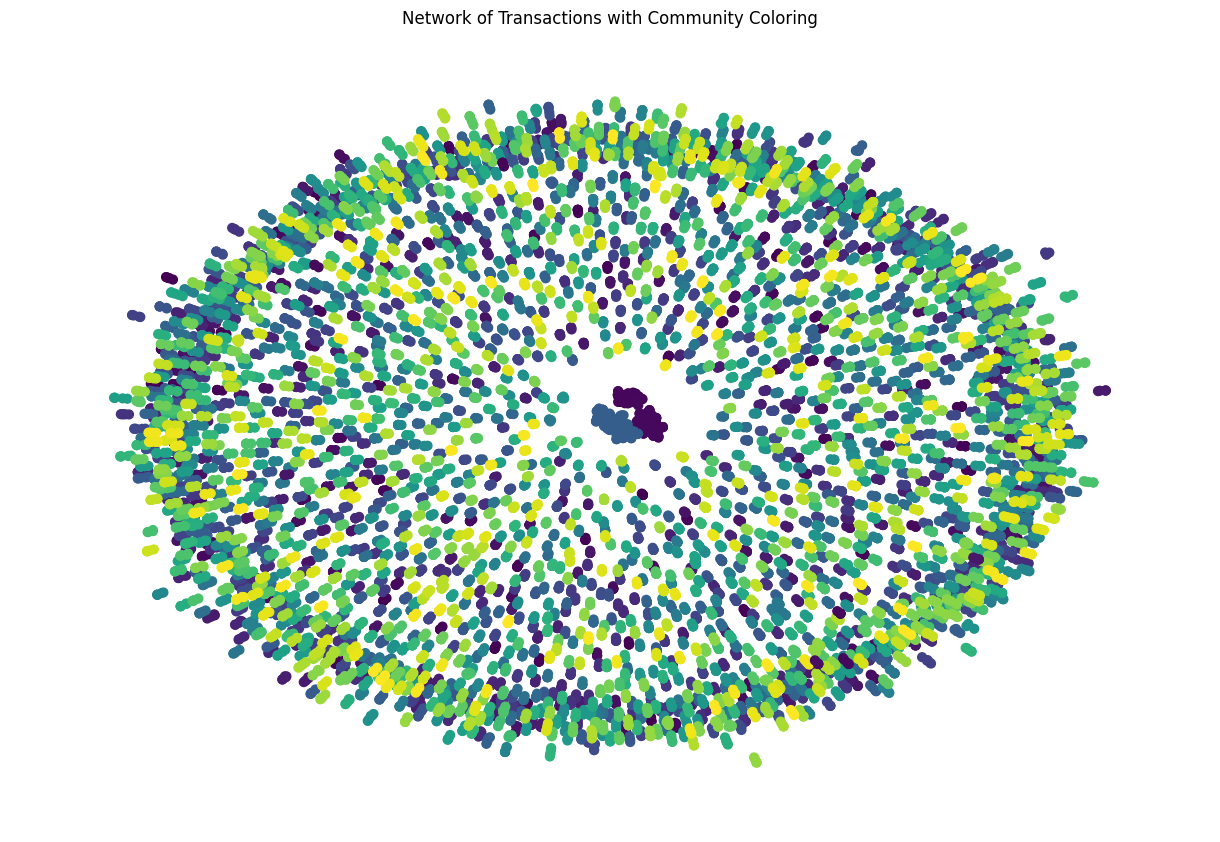

In [ ]:
# Color map based on community ID
color_map = [data['community'] for node, data in G.nodes(data=True)]

plt.figure(figsize=(12, 8))
nx.draw(G, node_color=color_map, with_labels=False, node_size=40, edge_color='gray')
plt.title("Network of Transactions with Community Coloring")
plt.show()

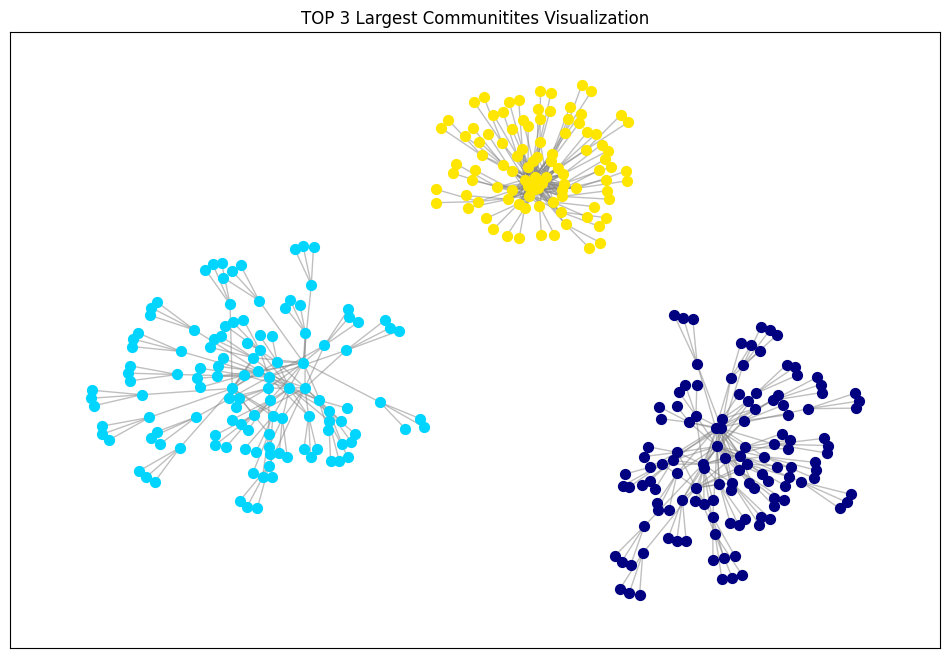

In [27]:
top_communities = sorted(all_communities, key=len, reverse=True)[:3]
filtered_nodes = [node for comm in top_communities for node in comm]
G_top = G.subgraph(filtered_nodes)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G_top)
for comm_id, nodes in enumerate(top_communities):
    nx.draw_networkx_nodes(G_top, pos, nodelist = nodes, node_size=50,
                           node_color = plt.cm.jet(comm_id/len(top_communities)))
nx.draw_networkx_edges(G_top, pos, alpha=0.5, edge_color='gray')
plt.title("TOP 3 Largest Communitites Visualization")
plt.show()

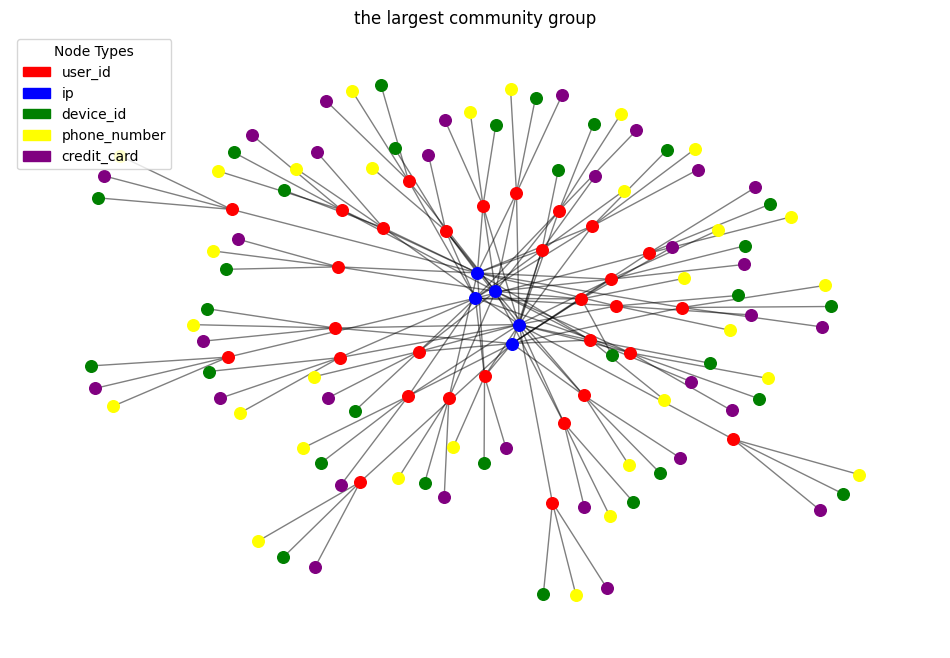

In [25]:
largest_community = max(all_communities, key=len)
G_largest = G.subgraph(largest_community)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G_largest) # 노드 위치 계산

node_types = {
    'user_id' : 'red',
    'ip' : 'blue',
    'device_id' : 'green',
    'phone_number' : 'yellow',
    'credit_card' : 'purple'
}

# 노드 그리기
for node_type, color in node_types.items():
    nx.draw_networkx_nodes(G_largest, pos, nodelist=[n for n in G_largest if G_largest.nodes[n]['node_type']==node_type],
                           node_color=color,
                           node_size=70,
                           label=node_type)
    
nx.draw_networkx_edges(G_largest, pos, alpha=0.5)

patches = [mpatches.Patch(color=color, label=node_type) for node_type, color in node_types.items()]
plt.legend(handles=patches, title='Node Types',loc='upper left')

plt.title("the largest community group")
plt.axis('off')
plt.show()

특정 ip 중심으로 커뮤니티 이어짐.   
즉 사기 집단에서 거래를 행할 때 기기나 핸드폰 번호는 계속해서 변경하지만 ip는 rmfjwl ahtgka.  
후속 조치로는 해당 ip를 더 자세히 분석해 proxy를 통한 접속인지, 해외 ip인지 등에 대해 살펴보고 블랙리스트에 등록하거나, 추후 다른 거래가 해당 ip를 통해 접속했을 시 위험 알림을 주도록 설정하는 방법이 있음  